## **Anime recommender System**


<img src="https://cdna.artstation.com/p/assets/images/images/002/181/886/large/pixel-motron-lastsupper-animecrossover-by-pixelmotron.jpg?1458327976" width ="800">


In this notebook, we will explore creating simple recommender systems using the following techniques:

* **[Popularity Model](https://hackernoon.com/popularity-based-song-recommendation-system-without-any-library-in-python-12a4fbfd825e):** As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up. The problem is that, it might not give personalized recommendations.This model works well most of the times because people like things other people might like. For e.g: Many people have watched Dragon Ball Z. There are so many pop culture references about DBZ that people who generally dont like anime might have watched/ would prefer watching the show.



* **[Content Based Filtering Algorithm:](http://http://recommender-systems.org/content-based-filtering/)** This method will try to find similarities between the content ( Anime series in this case) using attributes and metadata about the content and try to recommend items with highest similarity to what our active user liked in the past.



* **[Collaborative filtering algorithm](https://en.wikipedia.org/wiki/Collaborative_filtering):** This method will try to find similar users like the active user (the user for whom we are going to make predictions). Based on certain similarity metrics, we then suggest items ( anime titles in our case) that the similar users liked(gave higher ratings to) which were not rated by our active users.


* [**Hybrid Algorithm:** ](http://https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems) This method is a hybrid between the Collaborative filtering algorithm and the content based filtering algorithm. It has been seen that these algorithms work the best and provide solutions to cold strart related issues. Cold start occurs when we have a new user/ item in our dataset and we do not have sufficient information about the user/ item to make recommendations


(Inspired by Gabriel Moreira's Kaggle Notebook on Recommender Systems)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 4000
from sklearn.metrics.pairwise import cosine_similarity
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/anime-recommendations-database/rating.csv
/kaggle/input/anime-recommendations-database/anime.csv


In [2]:
# Read data
anime_data= pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')
rating_data=pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')

## Exploring our Data

In [3]:
# Checking basic information about our dataset
anime_data.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_data.describe()
# The data consists of 12294 different Anime titles, it has 12064 ratings (which means some ratings are Null)

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [5]:
rating_data.head()
#This data contains Iser ID, Anime Id and User rating for that anime from 0 to 10.
#Items which have a rating of -1 have not been rated yet.

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [6]:
rating_data.describe()
# Rating data has 7.8 Million Ratings

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [7]:
# replacing -1 to np.Nan in rating data
rating_data.rating.replace(-1, np.NaN,inplace=True)

In [8]:
# Getting count of Nulls
print('Anime Data')
for i in anime_data.columns:
    print('Null counts in the column',i,':',sum(anime_data[i].isna()))

print('\n Rating Data')
for i in rating_data.columns:
    print('Null counts in the column',i,':',sum(rating_data[i].isna()))

Anime Data
Null counts in the column anime_id : 0
Null counts in the column name : 0
Null counts in the column genre : 62
Null counts in the column type : 25
Null counts in the column episodes : 0
Null counts in the column rating : 230
Null counts in the column members : 0

 Rating Data
Null counts in the column user_id : 0
Null counts in the column anime_id : 0
Null counts in the column rating : 1476496


Getting so many NAs in ratings is understandable and a very common issue in User-Rating data. 
This is because, not every user will rate every anime in the list of anime shows out there!

In [9]:
# replacing -1 to np.Nan in rating data
anime_data.genre.replace(np.NaN,'None_Genre',inplace=True)
anime_data.type.replace(np.NaN,'None_type',inplace=True)
anime_data.episodes.replace('Unknown',np.NaN,inplace=True)

## EDA

**EDA on anime_data **

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import collections
import operator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

Average Rating: 6.473901690981445


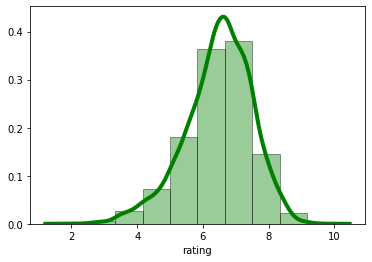

In [11]:
# On average, they have a rating of 6
sns.distplot(anime_data['rating'], hist=True, kde=True, 
             bins=10, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
print('Average Rating:',anime_data['rating'].mean())

Average members: 18071.33886448674
Max members: 1013917
Min members: 5
Median members: 1550.0


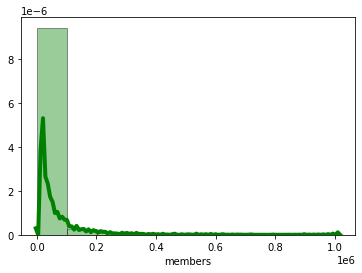

In [12]:
# On average, they have a rating of 6
sns.distplot(anime_data['members'], hist=True, kde=True, 
             bins=10, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
print('Average members:',anime_data['members'].mean())
print('Max members:',anime_data['members'].max())
print('Min members:',anime_data['members'].min())
print('Median members:',anime_data['members'].median())

In [13]:
## Check the top 10 anime with max members
anime_data.sort_values('members',ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


In [14]:
## Check the bottom 10 anime titles
anime_data.sort_values('members',ascending=True).head(10)

,anime_id,name,genre,type,episodes,rating,members
10997,34527,Gou-chan. Moko to Chinjuu no Mori no Nakama-tachi,"Adventure, Kids",Movie,1,NaN,5
10990,34485,Ganko-chan,None_Genre,None_type,NaN,NaN,11
10444,34490,Sushi Azarashi,Comedy,TV,30,3.00,12
10424,33320,Suijun Genten,None_Genre,Movie,1,7.00,13
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
10719,33319,Wareware no Heya,None_Genre,Movie,1,8.00,15
8367,34259,Chotto Ugoku!? &quot;Futeneko&quot;,Comedy,OVA,1,6.00,17
10989,34488,Gan Gan Ganko-chan,"Comedy, Kids, Sci-Fi",TV,NaN,NaN,19
9805,34363,Ocha-ken: Ryokutto Monogatari,"Kids, Slice of Life",TV,13,8.00,20
9701,33826,Neko no Kuni no Kenpou,Historical,OVA,1,7.33,20


Many of these anime titles dont even have a Rating / Genre (I am not surprised! )

In [15]:
anime_data.episodes=pd.to_numeric(anime_data.episodes, errors='coerce')

Average Episode Count: 12.382549774134182
Max Episode Count: 1818.0
Min Episode Count: 1.0
Median Episode Count: 2.0


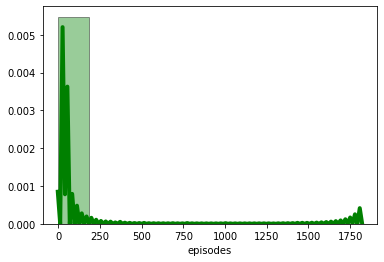

In [16]:
# On average, they have aroud 12 episodes per series
sns.distplot(anime_data['episodes'], hist=True, kde=True, 
             bins=10, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
print('Average Episode Count:',anime_data['episodes'].mean())
print('Max Episode Count:',anime_data['episodes'].max())
print('Min Episode Count:',anime_data['episodes'].min())
print('Median Episode Count:',anime_data['episodes'].median())

In [17]:
# Anime series with highest number of episodes
anime_data.sort_values('episodes', ascending = False).head(10)

,anime_id,name,genre,type,episodes,rating,members
6296,12393,Oyako Club,"Comedy, Slice of Life",TV,1818.0,6.18,160
929,2471,Doraemon (1979),"Adventure, Comedy, Fantasy, Kids, Sci-Fi, Shounen",TV,1787.0,7.76,14233
9243,23349,Kirin Monoshiri Yakata,Kids,TV,1565.0,5.56,116
5360,6277,Manga Nippon Mukashibanashi (1976),"Fantasy, Historical",TV,1471.0,6.48,406
6580,8213,Hoka Hoka Kazoku,Comedy,TV,1428.0,6.05,194
9242,32448,Kirin Ashita no Calendar,"Historical, Kids",TV,1306.0,6.43,59
9613,22221,Monoshiri Daigaku: Ashita no Calendar,Historical,TV,1274.0,6.80,112
10165,10241,Sekai Monoshiri Ryoko,Comedy,TV,1006.0,5.92,153
9317,20117,Kotowaza House,"Comedy, Slice of Life",TV,773.0,5.63,110
6118,9768,Shima Shima Tora no Shimajirou,"Adventure, Comedy, Fantasy, Kids, Magic",TV,726.0,6.25,237


In [18]:
anime_data['type'].value_counts()

TV           3787
OVA          3311
Movie        2348
Special      1676
ONA           659
Music         488
None_type      25
Name: type, dtype: int64

Average rating for Movie anime: 6.318058336961246
Average rating for TV anime: 6.902299101062382
Average rating for OVA anime: 6.375220700152198
Average rating for Special anime: 6.523500897666066
Average rating for Music anime: 5.588995901639343
Average rating for ONA anime: 5.643297546012272
Average rating for None_type anime: nan


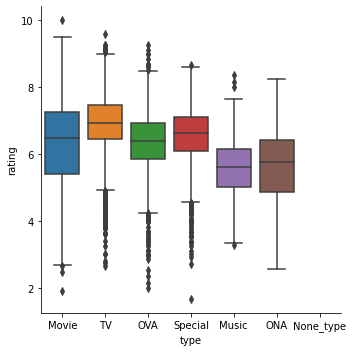

In [19]:
# Checking rating across different type of anime
sns.catplot(x="type", y="rating", kind="box", data=anime_data)

for i in anime_data['type'].unique():
    print('Average rating for',i,'anime:',anime_data[anime_data.type==i]['rating'].mean())

 We notice that, on an average rating for TV anime is higher ~ 7
 
 Average rating for Musical Anime is lower ~ 5.5


In [20]:
anime_data['genre']=anime_data['genre'].apply(lambda x : x.split(', '))

[Text(0, 0.5, 'Genre'), Text(0.5, 0, 'Count')]

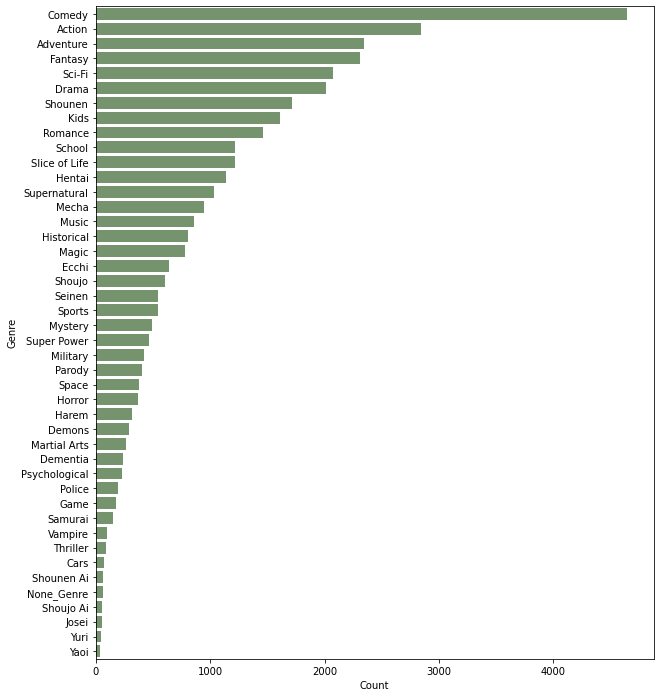

In [21]:
genre_data = itertools.chain(*anime_data['genre'].values.tolist())
genre_counter = collections.Counter(genre_data)
genres = pd.DataFrame.from_dict(genre_counter,orient='index').reset_index()
genres.columns=['Genre','Counts']
genres.sort_values('Counts', ascending=False, inplace=True)

# Plot genre
f, ax = plt.subplots(figsize=(10,12))
sns.barplot(x="Counts", y="Genre", data=genres, color='#719967')
ax.set(ylabel='Genre',xlabel="Count")

Our list mostly comprises of comedy anime titles, followed by Action, adventure and fantasy titles

In [22]:
# Getting rankings by genre
genre_rating = []
for i in list(genres['Genre']):
    genre_rating.append(anime_data[anime_data['genre'].str.contains(i, regex=False)]['rating'].mean())

genre_rating_dict=pd.DataFrame({'Genre': list(genres['Genre']),
  'rating': genre_rating })
genre_rating_dict.sort_values('rating', ascending=False, inplace=True)

[Text(0, 0.5, 'Genre'), Text(0.5, 0, 'Rating')]

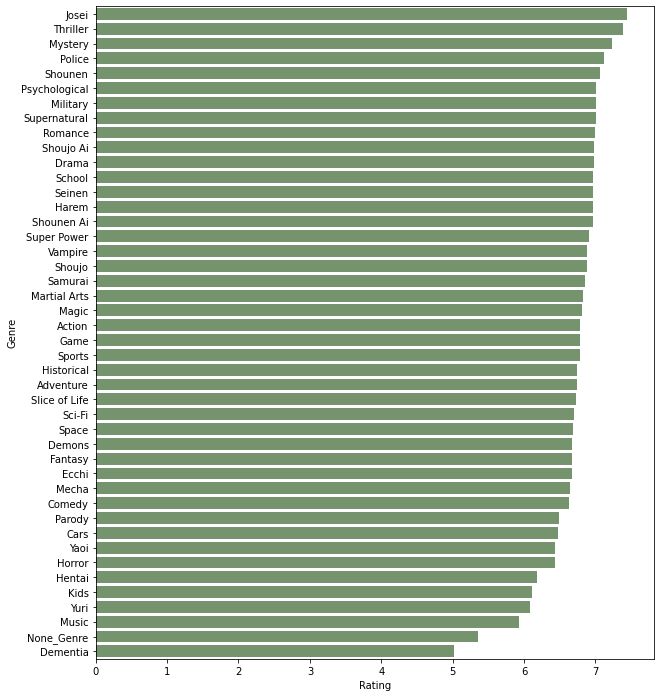

In [23]:
# Plot Genre - Ratings 
f, ax = plt.subplots(figsize=(10,12))
sns.barplot(x="rating", y="Genre", data=genre_rating_dict, color='#719967')
ax.set(ylabel='Genre',xlabel="Rating")


Not much variation in average ratings for different genres. 

* Josei anime tends to have a higher rating averaging at 7 points. This can also because these anime titles have lower number of titles.

* Dementia anime series are at the tail end of ratings and average on around 5 points.

* Most of the remaining anime titles are averaging between 6-7 points 

**EDA on Rating dataset**

In [24]:
rating_anime=rating_data.merge(anime_data[['name','genre','anime_id','type','episodes','members']],left_on='anime_id',right_on='anime_id')

In [25]:
## Lets look at top 10 animes which have been rated the most in the dataset
top_rated= rating_anime.groupby(['anime_id','name']).count()['user_id'].reset_index().sort_values('user_id', ascending=False)
top_rated.head(10)

,anime_id,name,user_id
1389,1535,Death Note,39340
6606,11757,Sword Art Online,30583
7439,16498,Shingeki no Kyojin,29584
1427,1575,Code Geass: Hangyaku no Lelouch,27718
201,226,Elfen Lied,27506
4630,6547,Angel Beats!,27183
10,20,Naruto,25925
99,121,Fullmetal Alchemist,25032
3965,5114,Fullmetal Alchemist: Brotherhood,24574
3558,4224,Toradora!,24283


We see that the top 10 numbers are some of the higher and more mainstream anime titles like Naruto, Code Geass and Attack on Titan (Shingeki no Kyojin). This list does look similar to the list in the "anime_data" table

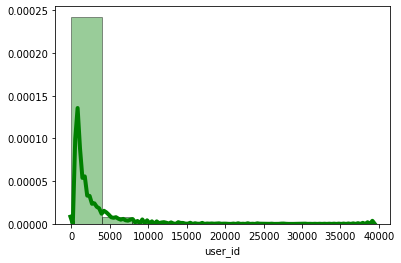

In [26]:
sns.distplot(top_rated['user_id'], hist=True, kde=True, 
             bins=10, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

**Long Tail Plot:** The above plot shows what is called the Long tail phenomenon. This plot is used to explore popularity patterns in user-item interaction data such as clicks, ratings, or purchases. Typically, only a small percentage of items have a high volume of interactions, and this is referred to as the “head”. Most items are in the “long tail”, but they only make up a small percentage of interactions. 


[Reference](http://https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093)

In [27]:
#http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

### Now that we have seen how our data looks like, let's Build our Recommender Systems!!!

In [28]:
train_df, test_df = train_test_split(rating_anime,
                                   test_size=0.20,
                                   random_state=27)

In [29]:
print( 'train:',train_df.shape[0])
print( 'Test:',test_df.shape[0])
# training data has 6.5 million interactions and test data has 1.5 million interactions

train: 6250981
Test: 1562746


## **Popularity Based Recommender System** 
* For our popularity based recommender system, we will be writing a function which takes the following parameters:
    * **N**= Number of Shows to recommend
    
    * **Genre** = A list of genres that the recommender system should recommend out of. By default, it will take all genre into consideration
    
    * **Type** = A list of the type of show that the user wants (e.g TV, Movie, OVA etc). By default, it will take all types into consideration
    
    * **episodes_more_than** an integer value which indicates how many integers that particular anime show should be more than. e.g for a value of 50, the system should only show the shows which have more than 50 episodes. by default, it is set to 0.
    * **Popularity Weight** = A value between 0 to 1.  A value of 1 means all the recommendations will be based on the popularity of the show. A value of 0 means all the recommendations will be based on the rating for the show. A value of 0.6 means, the popularity will be given a 60% weightage and 40% weightage will be given to the rating of a show

In [30]:
def popularity_recommender(dataset,N = 0, 
                           Genre =[],
                           Type= [],
                           episodes_more_than=0,
                           popularity_weight= 0.5
                          ):    
    if len(Genre)==0:
        Genre = ['Josei', 'Thriller', 'Mystery', 'Police', 'Shounen', 'Psychological', 'Military', 'Supernatural', 'Romance', 'Shoujo Ai', 'Drama', 'School', 'Seinen', 'Harem', 'Shounen Ai', 'Super Power', 'Vampire', 'Shoujo', 'Samurai', 'Martial Arts', 'Magic', 'Action', 'Game', 'Sports', 'Historical', 'Adventure', 'Slice of Life', 'Sci-Fi', 'Space', 'Demons', 'Fantasy', 'Ecchi', 'Mecha', 'Comedy', 'Parody', 'Cars', 'Yaoi', 'Horror', 'Hentai', 'Kids', 'Yuri', 'Music', 'None_Genre', 'Dementia']
    if len(Type) ==0:
        Type = ['ONA', 'None_type', 'OVA', 'Special', 'Music', 'Movie', 'TV']

    pop_recommender_df = dataset[
    (dataset.episodes>=episodes_more_than) &
    (dataset.genre.apply(len) !=(dataset.genre.apply(set)- set(Genre)).apply(len)) &
    (dataset.type.isin(Type)) ].copy()
       
    if len(pop_recommender_df)==0:
        print('No anime found with such conditions')

    else:
        # anime rating is in a range of 1 to 10 while popularity/members is in a larger range. 
        # because we want to show good shows with higher popularity, we will scale popularity on a range of 1 to 10 
        # we shall be giving 70% weight to the popularity metric and 30% weight to show rating and calculate a new score called Popularity_quality_index
        pop_recommender_df['scaled_members']=(minmax_scale(pop_recommender_df.members))*10
        pop_recommender_df['Popularity_quality_index']=(popularity_weight* pop_recommender_df.scaled_members)+(1-popularity_weight)*pop_recommender_df.rating
        df=pop_recommender_df.sort_values('Popularity_quality_index', ascending=False).iloc[0:N]
        cols =['name','genre','type','episodes','rating','members']
        return(df[cols])


In [31]:
genre_list=['Action']
Type_list = ['Movie']
popularity_recommender(anime_data,
                       Genre=genre_list,
                       episodes_more_than=0,
                       Type=Type_list,
                       N=20,
                       popularity_weight=0.4)

,name,genre,type,episodes,rating,members
24,Mononoke Hime,"[Action, Adventure, Fantasy]",Movie,1.0,8.81,339556
191,Ghost in the Shell,"[Action, Mecha, Police, Psychological, Sci-Fi,...",Movie,1.0,8.34,223036
358,Akira,"[Action, Adventure, Horror, Military, Sci-Fi, ...",Movie,1.0,8.15,215897
90,Evangelion: 2.0 You Can (Not) Advance,"[Action, Mecha, Sci-Fi]",Movie,1.0,8.53,182224
294,Evangelion: 1.0 You Are (Not) Alone,"[Action, Mecha, Sci-Fi]",Movie,1.0,8.21,194561
834,Kara no Kyoukai 1: Fukan Fuukei,"[Action, Mystery, Supernatural, Thriller]",Movie,1.0,7.81,178880
152,Cowboy Bebop: Tengoku no Tobira,"[Action, Drama, Mystery, Sci-Fi, Space]",Movie,1.0,8.40,137636
136,Stranger: Mukou Hadan,"[Action, Adventure, Historical, Samurai]",Movie,1.0,8.43,125503
45,Kara no Kyoukai 5: Mujun Rasen,"[Action, Drama, Mystery, Romance, Supernatural...",Movie,1.0,8.68,111074
607,Final Fantasy VII: Advent Children,"[Action, Fantasy, Super Power]",Movie,1.0,7.94,138659


Looks really good! I can see some of the popular Anime titles in this list. Because we have the ability to assign weights and tune our list of recommendations, and subset our results, its a very easy to use and intuitive solution.

However, this method wont give you personalized recommendations.

# Content Based Recommender System

In [96]:
anime_genre_dummies= pd.get_dummies(anime_data.genre.apply(pd.Series).stack()).sum(level=0)
anime_genre_dummies=pd.concat([anime_data, anime_genre_dummies], axis=1)


In [97]:
def get_episode_encoding(num_episodes):
    if(num_episodes<=13):
        return('Xsmall')
    elif (num_episodes<=50):
        return('Small')
    elif (num_episodes<=250):
        return('Medium')
    elif (num_episodes<=500):
        return('Long')
    else:
        return('Xlong')

In [98]:
# Engineering a few features

#Making one hot encodings for type, Number of Episodes, and if the show is a very popular show, has medium popularity or lesser known popularity
# Getting Show Type dummies
anime_genre_dummies = pd.concat([anime_genre_dummies,pd.get_dummies(anime_data.type)],axis = 1)

# Getting Episode size categories
anime_genre_dummies = pd.concat([anime_genre_dummies,pd.get_dummies(anime_genre_dummies.episodes.apply(get_episode_encoding))],axis=1)

req_cols = list(set(anime_genre_dummies.columns) -set(['anime_id','name','genre','type','episodes','rating','members']))
req_cols.sort()

# Creating Encodings
anime_genre_dummies['Encoding']=anime_genre_dummies[req_cols].values.tolist()
anime_genre_dummies

,anime_id,name,genre,type,episodes,rating,members,Action,Adventure,Cars,...,ONA,OVA,Special,TV,Long,Medium,Small,Xlong,Xsmall,Encoding
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,0,0,0,...,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,1,1,0,...,0,0,0,1,0,1,0,0,0,"[1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,1,0,0,...,0,0,0,1,0,1,0,0,0,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,0,0,0,...,0,0,0,1,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,1,0,0,...,0,0,0,1,0,1,0,0,0,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,[Hentai],OVA,1.0,4.15,211,0,0,0,...,0,1,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
12290,5543,Under World,[Hentai],OVA,1.0,4.28,183,0,0,0,...,0,1,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
12291,5621,Violence Gekiga David no Hoshi,[Hentai],OVA,4.0,4.88,219,0,0,0,...,0,1,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,[Hentai],OVA,1.0,4.98,175,0,0,0,...,0,1,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


This system will take the list of anime that the active user has watched. Based on the list of anime, we will try to find similar items in our list of anime. We are using Cosine similarity to find similarities between the active user's profile and the titles listed in our database

The function takes the following parameters:
* **user_profile** = This will be the list of anime shows rated by our user
* **N** = Number of recommendations to suggest to the Active User
* **movie_profile ** = Content database

In [90]:
def content_based_recommender(user_id,N,movie_profile):
    # get user profile
    user_profile=train_df[train_df['user_id']==user_id].copy().reset_index(drop = True)
    user_profile = user_profile[user_profile.rating.notna()]
    cols_to_merge= list(set(movie_profile.columns)-set(['rating']))
    user_profile =pd.merge(user_profile[['anime_id','rating']],movie_profile[cols_to_merge]
             ,how= 'left', left_on='anime_id', right_on='anime_id')
    
    req_cols = list(set(movie_profile.columns) -set(['anime_id','name','genre','type','episodes','rating','members','Encoding']))
    req_cols.sort()
    # to generate the user profile, we are summing up the genre dummy variables that the user
    #interacted with and weighing it with the rating that the user has given to the interacted items 
    user_profile['rating_scaled'] =  minmax_scale(user_profile['rating'])
    
    # Multiplying Ratings with the genre encodings
    genre_weights=pd.DataFrame(user_profile[req_cols].multiply(user_profile['rating_scaled'],axis="index").sum()).reset_index()
    genre_weights.columns=['Genre','Weights']
    
    #Scaling the encodings so that we have encodings in 0-1 range to compare with movie encodings
    genre_weights['weights_scaled']=minmax_scale(genre_weights['Weights'])
    user_profile_weights= [list(genre_weights['weights_scaled'])]
    
    # Finding cosine similarity between user profile and movies 
    movie_profile['user_affinity']= cosine_similarity(user_profile_weights,list(movie_profile['Encoding']))[0]
    
    return(movie_profile.sort_values('user_affinity', ascending = False).reset_index().iloc[1:N][['name','genre','type','episodes','rating','members','user_affinity']])


In [103]:
content_based_recommender(user_id = 8, N= 10,movie_profile = anime_genre_dummies)

,name,genre,type,episodes,rating,members,user_affinity
1,"Ore, Twintail ni Narimasu.","[Action, Comedy, Fantasy, Romance, School, Sho...",TV,12.0,6.76,66868,0.792845
2,Dragon Drive,"[Action, Adventure, Comedy, Fantasy, School, S...",TV,38.0,6.88,14232,0.791472
3,Hitsugi no Chaika: Avenging Battle,"[Action, Adventure, Comedy, Fantasy, Romance, ...",TV,10.0,7.33,91049,0.787015
4,Hitsugi no Chaika,"[Action, Adventure, Comedy, Fantasy, Romance, ...",TV,12.0,7.47,164510,0.787015
5,Tobe! Isami,"[Action, Adventure, Comedy, Romance, Shounen]",TV,50.0,7.43,854,0.785264
6,Dungeon ni Deai wo Motomeru no wa Machigatteir...,"[Action, Adventure, Comedy, Fantasy, Romance]",TV,13.0,7.88,336349,0.779032
7,Gakusen Toshi Asterisk,"[Action, Comedy, Ecchi, Fantasy, Harem, Romanc...",TV,12.0,7.14,168657,0.775572
8,Busou Renkin,"[Action, Comedy, Fantasy, School, Shounen, Sup...",TV,26.0,7.51,104607,0.775355
9,Totsugeki! Pappara-tai,"[Action, Comedy, Romance]",TV,25.0,6.57,255,0.774281


Based on the recommendations for user 8, we can see that the user really likes Action, Rom-Com and High School based anime!

Note that the Content based Recommender System is not giving highly rated or popular anime series. This recommender system will provide items similar to the content that the user has seen and rated currently.
Factors like: Genre, type of Anime and Number of episodes are the factors that the recommender system uses to find similar other content!

# Collaborative Filtering Recommender System